In [1]:
import tensorflow as tf

In [2]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt 
import os

In [3]:
tf.__version__

'2.0.0'

In [4]:
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                   fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [6]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips'],
      dtype='<U10')

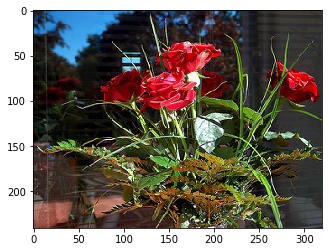

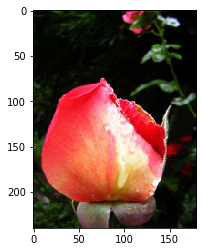

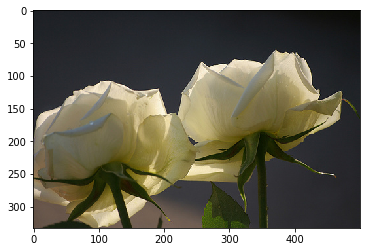

In [7]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    #display.display(Image.open(str(image_path)))
    plt.imshow(Image.open(str(image_path)))
    plt.show()

In [8]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [9]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count / BATCH_SIZE)

In [10]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes=list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [11]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

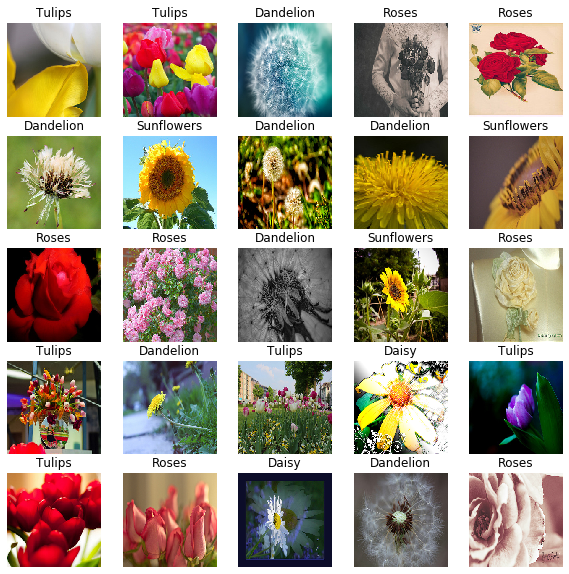

In [12]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [13]:
list_ds = tf.data.Dataset.list_files(str(data_dir / '*/*'))

In [17]:
for f in list_ds.take(5):
    print(f.numpy())

b'/home/kitamura/.keras/datasets/flower_photos/roses/3921794817_276eb4386b.jpg'
b'/home/kitamura/.keras/datasets/flower_photos/dandelion/13675534854_03caf51644_m.jpg'
b'/home/kitamura/.keras/datasets/flower_photos/tulips/466409031_4c10294db5_m.jpg'
b'/home/kitamura/.keras/datasets/flower_photos/dandelion/10777398353_5a20bb218c.jpg'
b'/home/kitamura/.keras/datasets/flower_photos/sunflowers/200288046_0032f322ff_n.jpg'


In [18]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES

In [19]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [20]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [23]:
for image, label in labeled_ds.take(1):
    print("Image shape : ", image.numpy().shape)
    print("Label : ", label.numpy())

Image shape :  (224, 224, 3)
Label :  [False False  True False False]


In [33]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
        
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    
    ds = ds.batch(BATCH_SIZE)
    
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [26]:
train_ds = prepare_for_training(labeled_ds)
image_batch, label_batch = next(iter(train_ds))

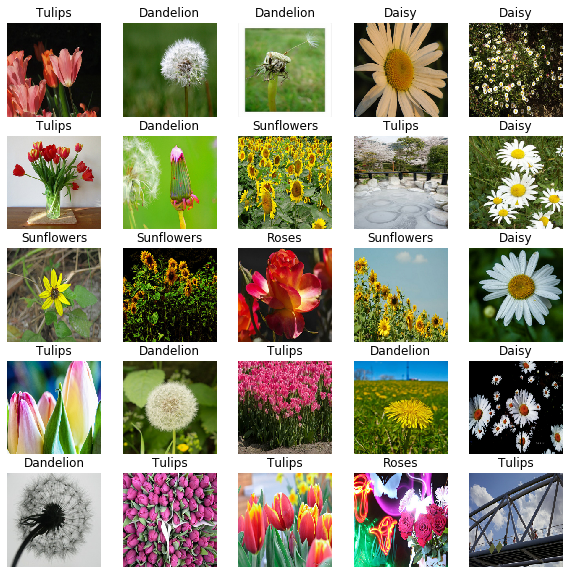

In [27]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [28]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
    start = time.time()
    it = iter(ds)
    
    for i in range(steps):
        batch = next(it)
        if i % 10 == 0:
            print('.', end='')
    print()
    end = time.time()
    
    duration = end - start
    print("{} batches : {} s".format(steps, duration))
    print("{:0.5f} Images/s".format(BATCH_SIZE * steps / duration))

In [29]:
timeit(train_data_gen)

....................................................................................................
1000 batches : 54.17047691345215 s
590.72768 Images/s


In [30]:
timeit(train_ds)

....................................................................................................
1000 batches : 5.245882987976074 s
6100.02169 Images/s


In [31]:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

....................................................................................................
1000 batches : 19.035885095596313 s
1681.03557 Images/s


In [34]:
filecache_ds = prepare_for_training(labeled_ds, cache='./flowers.tfcache')
timeit(filecache_ds)

....................................................................................................
1000 batches : 11.866785764694214 s
2696.60215 Images/s
